### single model

Firstly, we use a single model to train on curated subset.

In [1]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count

import numpy as np
import librosa
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR
# from torch.optim.lr_scheduler import CyclicLR
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.set_device(3)

### utils

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2019
seed_everything(SEED)

In [6]:
N_JOBS = cpu_count()
used = int(4)
print(N_JOBS, used)
os.environ['MKL_NUM_THREADS'] = str(used)
os.environ['OMP_NUM_THREADS'] = str(used)
DataLoader = partial(DataLoader, num_workers=used)

56 4


### metric definition
calculate lwlrap for task2.

In [7]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

### dataset

In [8]:
dataset_dir = Path('/media/ky02/dcase2019-data/task2')
preprocessed_dir = Path('./work/fat2019_prep_mels_2s') # time duration of audio croped, 2s 4s1 4s2 2s_pcen;
print(os.listdir(preprocessed_dir))

['mels_train_noisy.pkl', 'trn_noisy_best50s.csv', 'mels_trn_noisy_best50s.pkl', 'mels_test.pkl', 'mels_train_curated.pkl']


In [9]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    'train_noisy': dataset_dir / 'train_noisy.csv',
#     'train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_train_noisy.pkl', # 'mels_trn_noisy_best50s.pkl'
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [10]:
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
# train_df = pd.concat([train_curated, train_noisy],sort=True,ignore_index=True)
train_df = pd.concat([train_curated], sort=True, ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [11]:
test_df = pd.read_csv(csvs['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
labels = test_df.columns[1:].tolist()
# print(labels)
num_classes = len(labels)
num_classes

80

In [13]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(4970, 80)

In [14]:
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    print(len(x_train))
#     x_train.extend(pickle.load(noisy))
#     print(len(x_train))

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

4970


(4970, 1120)

### Data loader

In [15]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        # crop 1sec
        image = Image.fromarray(self.mels[idx], mode='RGB')        
        time_dim, base_dim = image.size
#         print('Shape: ',time_dim, base_dim)
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
#         print(type(image))
        image = self.transforms(image).div_(255)
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label

In [16]:
class FATTestDataset(Dataset):
    def __init__(self, fnames, mels, transforms, tta=5):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.transforms = transforms
        self.tta = tta
        
    def __len__(self):
        return len(self.fnames) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.fnames)
        
        image = Image.fromarray(self.mels[new_idx], mode='RGB')
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
        image = self.transforms(image).div_(255)
        fname = self.fnames[new_idx]
        return image, fname

## pytorch models

In [17]:
import torchvision.models as models
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# # To tune or design nn here.
model_type = 'inception' # 'resnet18' # 'inception' ‘alexnet’ ‘vgg’
model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)

ModuleNotFoundError: No module named 'torchsummary'

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)
        return x
# Classifier(num_classes=num_classes)

### mixup and loss function defination

In [21]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y
#     y_a, y_b = y, y[index]
#     return mixed_x, y_a, y_b, lam

def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [22]:
# similar with tf.nn.weighted_cross_entropy_with_logits 
def weighted_BCEWithLogits(pos_weight):
    def weighted_cross_entropy_with_logits(logits, targets):   # y_pred ,y_true
        return (targets * -logits.sigmoid().log() * pos_weight + (1 - targets) * -(1 - logits.sigmoid()).log()).mean()

    return weighted_cross_entropy_with_logits

In [24]:
# SpecAugment by Google, a modified version in pytorch.

from sparse_image_wrap import sparse_image_warp
class FrequencyMask(object):
    """
    Implements frequency masking transform from SpecAugment paper (https://arxiv.org/abs/1904.08779)
      Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     FrequencyMask(max_width=10, use_mean=False),
        >>> ])
    """

    def __init__(self):
        pass

    def time_warp(self, spec, W=10):
        num_rows = spec.shape[1]
        spec_len = spec.shape[2]
        device = spec.device

        y = num_rows//2
        horizontal_line_at_ctr = spec[0][y]
        assert len(horizontal_line_at_ctr) == spec_len

        point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
        assert isinstance(point_to_warp, torch.Tensor)

        # Uniform distribution from (0,W) with chance to be up to W negative
        dist_to_warp = random.randrange(-W, W)
        src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                             torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
        warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
        return warped_spectro.squeeze(3)
    
    def freq_mask(self,spec, F=30, num_masks=1, replace_with_zero=False):
        cloned = spec.clone()
        num_mel_channels = cloned.shape[1]

        for i in range(0, num_masks):        
            f = random.randrange(0, F)
            f_zero = random.randrange(0, num_mel_channels - f)

            # avoids randrange error if values are equal and range is empty
            if (f_zero == f_zero + f): return cloned

            mask_end = random.randrange(f_zero, f_zero + f) 
            if (replace_with_zero): cloned[0][f_zero:mask_end] = 0
            else: cloned[0][f_zero:mask_end] = cloned.mean()

        return cloned
    
    def time_mask(self,spec, T=30, num_masks=1, replace_with_zero=False):
        cloned = spec.clone()
        len_spectro = cloned.shape[2]

        for i in range(0, num_masks):
            t = random.randrange(0, T)
            t_zero = random.randrange(0, len_spectro - t)

            # avoids randrange error if values are equal and range is empty
            if (t_zero == t_zero + t): return cloned

            mask_end = random.randrange(t_zero, t_zero + t)
            if (replace_with_zero): cloned[0][:,t_zero:mask_end] = 0
            else: cloned[0][:,t_zero:mask_end] = cloned.mean()
        return cloned
        
    
    def __call__(self, spec):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) where the frequency mask is to be applied.
        Returns:
            Tensor: Transformed image with Frequency Mask.
        """
#         print('type and size', type(spec), spec.shape)
        b = torch.unsqueeze(spec[0,], 0)
#         print(b.shape)
        temp = self.time_mask(self.freq_mask(self.time_warp(b), num_masks=1), num_masks=1)
#         print('outputoutputoutputoutput',temp.shape)
        combined = torch.stack([temp[0,], temp[0,], temp[0,]], 0)
   
        return combined        
         
    def __repr__(self):
        format_string = self.__class__.__name__ + "(max_width="
        format_string += str(self.max_width) + ")"
        return format_string


In [25]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        self.optimizer = optimizer
        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

### train

In [26]:
def train_model(x_train, y_train, train_transforms, val_transforms,
                model_path, num_epochs = 5, batch_size = 32, test_batch_size = 64):
    
    lr = 1e-3
    eta_min = 1e-7
    t_max = 20
    num_classes = y_train.shape[1]

    trn_loss = []
    val_loss = []
    val_lwlrap = []
    lr_log = []
    
    x_trn, x_val, y_trn, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=SEED)
    train_dataset = FATTrainDataset(x_trn, y_trn, train_transforms)
    valid_dataset = FATTrainDataset(x_val, y_val, val_transforms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)

    model = model_ft.cuda()
    # if continue to train
    if model_path and False:
        model.load_state_dict(torch.load(model_path))
    model.cuda()

    # loss function
    criterion = nn.BCEWithLogitsLoss().cuda()  # sigmoid 交叉熵
#     criterion=weighted_BCEWithLogits(0.7)
    # optimizer
#     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#     optimizer = optim.Adam([var1, var2], lr=0.0001)
#     optim.SGD([ {'params': model.base.parameters()},
#                 {'params': model.classifier.parameters(), 'lr': 1e-3}
#             ], lr=1e-2, momentum=0.9)
#     optimizer = Adadelta(params=model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0)
#     optimizer = Adagrad(params=model.parameters(), lr=lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
    optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)

    # learning rate
#     scheduler = MultiStepLR(optimizer, [20, 30, 40, 50], 0.1, last_epoch=10)
    scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
#     scheduler_clr = CyclicLR(optimizer, 1e-7, 1e-3, step_size=1200,\
#                          mode='exp_range', gamma=0.99994)#f, scale_fn=None, scale_mode='cycle',\
#     scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=6, verbose=True) 

    best_epoch = -1
    best_lwlrap = 0.
    mb = master_bar(range(num_epochs))
    for epoch in mb:
        start_time = time.time()
        model.train()
        avg_loss = 0.

        # train process
        for x_batch, y_batch in progress_bar(train_loader, parent=mb):
            # generate mixed inputs, two one-hot label vectors and mixing coefficient
            if mixup_on:
                x_batch, y_batch = mixup_data(x_batch, y_batch, alpha=1, use_cuda=True)
                
            if model_type != 'inception':
                preds = model(x_batch.cuda())
                loss = criterion(preds, y_batch.cuda())
            else:
                outputs, aux_outputs = model(x_batch.cuda())
                loss1 = criterion(outputs, y_batch.cuda())
                loss2 = criterion(aux_outputs, y_batch.cuda())
                loss = loss1 + 0.4*loss2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             if scheduler_clr:
#                 scheduler_clr.batch_step()        
            avg_loss += loss.item() / len(train_loader)
        
        # validation process
        model.eval()
        valid_preds = np.zeros((len(x_val), num_classes))
        avg_val_loss = 0.
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            preds = model(x_batch.cuda()).detach()
            loss = criterion(preds, y_batch.cuda())
            preds = torch.sigmoid(preds)
            valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()
            avg_val_loss += loss.item() / len(valid_loader)
            
        score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
        lwlrap = (score * weight).sum()
               
        scheduler.step() # for CosineAnnealingLR, CLR
#         scheduler.step(avg_val_loss) # for reduceLR
        
        # record the metrics
        for param_group in optimizer.param_groups:
            lr_temp = param_group['lr']
        lr_log.append(lr_temp)

        if (epoch + 1) % 1 == 0:
            elapsed = time.time() - start_time
            mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
            trn_loss.append(avg_loss)
            val_loss.append(avg_val_loss)
            val_lwlrap.append(lwlrap)
    
        if lwlrap > best_lwlrap:
            best_epoch = epoch + 1
            best_lwlrap = lwlrap
            best_train_loss = avg_loss
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            
    return {
        'best_epoch': best_epoch,
        'best_lwlrap': best_lwlrap,
        'best_train_loss':best_train_loss,
        'best_val_loss':best_val_loss,
        'trn_loss':trn_loss,
        'val_loss':val_loss,
        'val_lwlrap':val_lwlrap,
        'lr_log':lr_log
    }

In [27]:
num_epochs = 400
batch_size = 32
test_batch_size = 32
# to change it in the train_model function now, avoiding too long code in train_model function.
lr_method = 'cosine' # 'CLR' 'reduceLR' 
aug_flip = 'flip' # 'noflip'
mixup_on = True
# Initialize the model for this run
model_type = 'inception' # 'inception' # 'resnet18' # 'inception' ‘alexnet’ ‘vgg’
model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)
# model_ft = Classifier(num_classes=num_classes)
# input_size = 128

import autoaugment
from autoaugment import ImageNetPolicy

if aug_flip == 'flip':
    transforms_dict = {
        'train': transforms.Compose([
#             transforms.RandomResizedCrop(input_size),
            transforms.Resize(input_size),
#             transforms.RandomHorizontalFlip(0.5), # ImageNetPolicy(),
            transforms.ToTensor(),
#             FrequencyMask(),
#             SpecAugment(time_warping_para=80, frequency_masking_para=50,
#                  time_masking_para=50, frequency_mask_num=2, time_mask_num=2) 
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ]),
    }

In [28]:
model_path = './work/s2/a1aug2_tta0_cyc20_%(m)s_%(lr)s_%(aug)s.pt'% \
{'m':model_type, 'lr':lr_method, 'aug':aug_flip}
output_path = './work/s2/a1aug2_tta0_cyc20_%(m)s_%(lr)s_%(aug)s.csv'%\
{'m':model_type, 'lr':lr_method, 'aug':aug_flip}
print(model_path)

./work/s2/a1aug2_tta0_cyc20_inception_cosine_flip.pt


In [29]:
result = train_model(x_train, y_train, transforms_dict['train'], transforms_dict['test'],
                     model_path, num_epochs, batch_size, test_batch_size)

In [30]:
print('best_epoch:',result['best_epoch'])
print('best_lwlrap:',result['best_lwlrap'])
print('best_trn_loss:',result['best_train_loss'])
print('best_val_loss:',result['best_val_loss'])

best_epoch: 387
best_lwlrap: 0.8146731390475858
best_trn_loss: 0.03342244819737971
best_val_loss: 0.022595795064262347


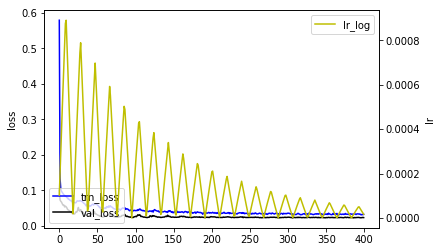

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.title("train loss, validation loss")
fig, ax1 = plt.subplots()
ax1.plot(result['trn_loss'], label='trn_loss', color='b')
ax1.plot(result['val_loss'], label='val_loss', color='k')
ax1.set_ylabel('loss', color='k')
ax1.legend(loc='lower left')
# ax1.ylim((0,1.))
ax2 = ax1.twinx()
ax2.plot(result['lr_log'], label='lr_log', color='y')
ax2.set_ylabel('lr', color = 'k')
ax2.legend(loc='upper right')

plt.show()

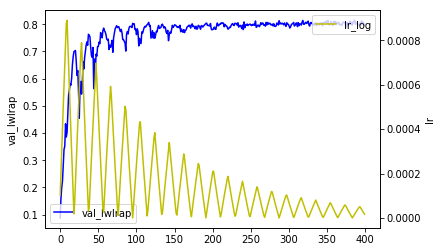

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.title("train loss, validation loss")
fig, ax1 = plt.subplots()
ax1.plot(result['val_lwlrap'], label='val_lwlrap', color='b')
ax1.set_ylabel('val_lwlrap', color='k')
ax1.legend(loc='lower left')
# ax1.ylim((0,1.))
ax2 = ax1.twinx()
ax2.plot(result['lr_log'], label='lr_log', color='y')
ax2.set_ylabel('lr', color = 'k')
ax2.legend(loc='upper right')

plt.show()

### predict

In [33]:
def predict_model(test_fnames, x_test, test_transforms, num_classes, tta=25):
    batch_size = 32

    test_dataset = FATTestDataset(test_fnames, x_test, test_transforms, tta=tta)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#    model = Classifier(num_classes=num_classes)

    model = model_ft
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()

    all_outputs, all_fnames = [], []

    pb = progress_bar(test_loader)
    for images, fnames in pb:
        preds = torch.sigmoid(model(images.cuda()).detach())
        all_outputs.append(preds.cpu().numpy())
        all_fnames.extend(fnames)

    test_preds = pd.DataFrame(data=np.concatenate(all_outputs),
                              index=all_fnames,
                              columns=map(str, range(num_classes)))
    test_preds = test_preds.groupby(level=0).mean()

    return test_preds

In [34]:
# torch.cuda.set_device(0)
start_time = time.time()
test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], num_classes)

In [35]:
test_df[labels] = test_preds.values
test_df.to_csv(output_path, index=False)

elapsed = time.time() - start_time
print(f'Prediction time: {elapsed:.0f}s')

Prediction time: 116s


In [36]:
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000002,0.000007,0.000020,0.000011,0.000182,0.003579,0.000014,0.000147,0.005112,...,0.000082,0.000012,0.000435,0.000175,0.000135,0.000015,0.005267,0.015316,0.000074,0.000358
1,0012633b.wav,0.251929,0.003341,0.009871,0.006555,0.001416,0.007855,0.036341,0.002297,0.000402,...,0.012089,0.020069,0.000560,0.000944,0.002631,0.001145,0.000879,0.011085,0.001024,0.025380
2,001ed5f1.wav,0.008129,0.004550,0.000449,0.003579,0.001239,0.002413,0.000170,0.002986,0.000463,...,0.002289,0.002474,0.004827,0.003078,0.002459,0.002533,0.001135,0.001645,0.003941,0.002512
3,00294be0.wav,0.000119,0.000134,0.000614,0.000307,0.001559,0.001830,0.000354,0.000182,0.003687,...,0.000912,0.000185,0.000573,0.000760,0.000181,0.000058,0.000825,0.011594,0.000711,0.001682
4,003fde7a.wav,0.000042,0.000732,0.000235,0.000007,0.000800,0.001257,0.000461,0.000152,0.796779,...,0.000089,0.000035,0.000594,0.000057,0.000097,0.000010,0.000052,0.000584,0.000080,0.000127


In [37]:
# 清除GPU存储
torch.cuda.empty_cache()